# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [37]:
# all import statements needed for the project, for example:
import os
import re
import bs4
import math
import requests
import keplergl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sqlalchemy as db
import geopandas as gpd
import scipy.stats as stats

In [38]:
#any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
TAXI_ZONES = "taxi_zones.zip"
WEATHER = "./weather/"
NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library.
* [ ] Taxi data:
    * [ ] Use the `re` module, and the packages `requests`, BeautifulSoup (`bs4`), and (optionally) `pandas` to programmatically download the required CSV files & load into memory.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* [ ] Weather & Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
* [ ] All data:
    * [ ] Load the data using `pandas`
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * (Taxi & Uber data) Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] (Taxi data) Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
* [ ] Weather data:
    * [ ] Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
    * [ ] You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 

### Calculating distance
From latitude and longitude to caluclate the distance. We refer to the formular from: https://en.wikipedia.org/wiki/Geographical_distance 

In [39]:
def calculate_distance(from_coord: pd.core.frame.DataFrame, to_coord: pd.core.frame.DataFrame) -> pd.core.series.Series:
    """Caluclate the distance from latitude and longitude.

    Keyword arguments:
    from_coord -- A dataframe including 'pickup_latitude' and 'pickup_longitude'
    to_coord -- A dataframe including 'dropoff_latitude' and 'dropoff_longitude'

    Output:
    A series of the distances (km).
    """

    # convert different degrees into radians
    pickup_larad = from_coord['pickup_latitude'].apply(math.radians)
    pickup_lorad = from_coord['pickup_longitude'].apply(math.radians)
    dropoff_larad = to_coord['dropoff_latitude'].apply(math.radians)
    dropoff_lorad = to_coord['dropoff_longitude'].apply(math.radians)

    # calculate the distance
    R = 6371 
    la_dif = pickup_larad - dropoff_larad
    lo_dif = pickup_lorad - dropoff_lorad
    a = ((la_dif / 2).apply(math.sin)) ** 2 + pickup_larad.apply(math.cos) * dropoff_larad.apply(math.cos) * ((lo_dif / 2).apply(math.sin) ** 2)
    distance = 2 * R * a.apply(math.sqrt).apply(math.asin)
    
    return distance

Add the distance information to the original dataframe.

In [40]:
def add_distance_column(dataframe: pd.core.frame.DataFrame) -> pd.core.frame.DataFrame:
    '''Add the distance information to the original dataframe.
    
    Keyword arguments:
    df -- A dataframe with columns "pickup_latitude" , "pickup_longitude",  "dropoff_latitude" and "dropoff_longitude".

    Output:
    A dataframe with a new column "distance"
    '''

    from_pos = dataframe[['pickup_latitude', 'pickup_longitude']]
    to_pos = dataframe[['dropoff_latitude', 'dropoff_longitude']]
    dataframe['distance'] = calculate_distance(from_pos, to_pos)
    
    return dataframe

### Processing Taxi Data

Download taxi data from URL and store them a big dataframe

In [53]:
def find_taxi_parquet_urls(taxi_url = TAXI_URL) -> list:
    '''Get the Urls of parquet files 
    
    Keyword arguments:
    taxi_url -- the website URL for downloading urls, given by default

    Output:
    A list of Urls each contains one month's taxi_data
    '''
    response = requests.get(taxi_url)
    html = response.content
    taxisoup = bs4.BeautifulSoup(html, 'html.parser')
    links = taxisoup.find_all("a", href=True)

    urllist = []
    for link in links:
        if re.search(r"yellow_tripdata_2009|yellow_tripdata_201[01234]|yellow_tripdata_2015-0[1-6]", link.get("href")):
            urllist.append(link.get("href"))
        # Regular expression to find the links that match the pattern 2009-01~2015-06
    return urllist
# myurl = find_taxi_parquet_urls()
# print(myurl)


In [44]:
def Download_data(localurl: str)-> pd.core.frame.DataFrame:    
    '''
    Download the data to local file path if there is non exist.
    url -- a string which is the url of the parquet file.
    return a dataframe that can we can further work on. 
    '''
    '''Functions to download the parquet file to local file path
    
    Keyword arguments:
    localurl -- URl for download 

    Output:
    NULL, but create some local files instead
    '''
    # Get the file name with given url
    filename = localurl.split('/')[-1]
    # download the file if it doesn't exist   
    if not os.path.exists(filename):
        file = requests.get(localurl)
        with open(filename , "wb") as f:
            f.write(file.content)
    # load the data with read_parquet
    df = pd.read_parquet(filename)
    print ('datadownloaded')
    #df.to_csv(filename+".csv")
    return df
# Download_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet')

def get_taxi_zone_df(filename = 'taxi_zones.zip') -> gpd.geodataframe.GeoDataFrame:
    '''Get a taxi_zone_dataframe
    
    Keyword arguments:
    filename -- The filename of a locally stored zip file

    Output:
    A GeoDataFrame with the taxi zone data
    '''
    taxi_zone_df = gpd.read_file(filename=filename, engine='fiona')
    # taxi_zone_df = gpd.read_file(TAXI_ZONES)
    taxi_zone_df = taxi_zone_df.to_crs(4326)
    taxi_zone_df['longitude'] = taxi_zone_df.centroid.x
    taxi_zone_df['latitude'] = taxi_zone_df.centroid.y
    taxi_zone_df.drop_duplicates('LocationID', inplace = True)
    taxi_zone_df.set_index('LocationID', inplace = True)
    return taxi_zone_df
# mypandas = get_taxi_zone_df()
# print(type((mypandas)))


def Clean_month_taxi_data(url: str, GEOmetry: gpd.geodataframe.GeoDataFrame) -> pd.core.frame.DataFrame:
    '''Clean the taxi data and return a dataframe for each month's data
    
    Keyword arguments:
    url--url to download, the geomotry information
    GEOmetry: A GeoDataFrame contains geological information

    Output:
    A dataframe that contains the information of 2500 of approixmately 25000 of a month's taxi_trip data
    '''
    # Call download_data fucntion to download data from url and return csv
    df = Download_data(localurl = url)
    print("cleaning data from", url)
    # looking up the latitude and longitude for some months where only location IDs are given for pickups and dropoffs
    if 'PULocationID' in df.columns:
        df['pickup_latitude'] = df['PULocationID'].map(GEOmetry['latitude'])
        df['pickup_longitude'] = df['PULocationID'].map(GEOmetry['longitude'])
        df['dropoff_latitude'] = df['DOLocationID'].map(GEOmetry['latitude'])
        df['dropoff_longitude'] = df['DOLocationID'].map(GEOmetry['longitude'])
    # Get rid of the NA's, which indicate a poor quality of the data.
    df.dropna()
    print(df)
    # normalizing column names
    df.rename(columns={
        'tpep_pickup_datetime':'pickup_datetime',\
        'Trip_Pickup_DateTime':'pickup_datetime',\
        'Trip_Dropoff_DateTime':'dropoff_datetime',\
        'tpep_dropoff_datetime':'dropoff_datetime',\
        'Start_Lon':'pickup_longitude', \
        'Start_Lat':'pickup_latitude', \
        'End_Lon':'dropoff_longitude', \
        'End_Lat':'dropoff_latitude',
        'Tip_Amt':'tip_amount'}, inplace=True)
    print('renamed')
    # normalizing and using appropriate column types for the respective data
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

    # removing trips that start and/or end outside of the NEW_YORK_BOX_COORDS
    df = df[(df['pickup_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['pickup_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['pickup_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['pickup_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude'] >= NEW_YORK_BOX_COORDS[0][0]) & (df['dropoff_latitude'] <= NEW_YORK_BOX_COORDS[1][0])]
    df = df[(df['dropoff_longitude'] >= NEW_YORK_BOX_COORDS[0][1]) & (df['dropoff_longitude'] <= NEW_YORK_BOX_COORDS[1][1])]


    # leaving only needed data columns, by selecting what's needed
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_datetime','dropoff_longitude','dropoff_latitude','tip_amount']]
    print(df)
    # sample the data to make it roughly equal to the size of the Uber dataset
    # ~200000 is the number of rows in the Uber dataset
    # so every month we sample 200000 / 78 ~ 2500 rows
    df = df.sample(n=2500)
    return df


In [45]:
def get_and_clean_taxi_data() -> pd.core.frame.DataFrame:
    '''Get all taxi_trip data 
    
    Keyword arguments:

    Output:
    a data frame that contains all the information of taxi data
    '''
    all_taxi_dataframes = []
    all_urls = find_taxi_parquet_urls(TAXI_URL)
    print(all_urls[0])
    GEOmetry = get_taxi_zone_df()
    count = 1
    for one_url in all_urls:
    # for one_url in [all_urls[66], all_urls[67]]:
        print(one_url)
        print("processing dataset" + str(count))
        dataframe = Clean_month_taxi_data(one_url, GEOmetry)
        add_distance_column(dataframe)
        all_taxi_dataframes.append(dataframe)
        count +=1
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data

### Processing Uber Data

Download and Read CSV file, storing them in a dataframe

In [46]:
def clean_uber_data(csv_file: str) -> pd.core.frame.DataFrame:
    '''Get a taxi_zone_dataframe
    
    Keyword arguments:
    csv_file -- A csv file that stored locally contains information of uber 

    Output:
    A Pandas dataframe with the uber data
    '''
    df = pd.read_csv(csv_file)
    df = df.drop(columns=["Unnamed: 0","key"])
    df = df.dropna()
    
    #pick up in bounding box 
    df = df[(df['pickup_longitude']> NEW_YORK_BOX_COORDS[0][1]) &  (df['pickup_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['pickup_latitude']> NEW_YORK_BOX_COORDS[0][0]) &  (df['pickup_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    #drop off in bounding box  
    df = df[(df['dropoff_longitude']> NEW_YORK_BOX_COORDS[0][1]) &  (df['dropoff_longitude']<NEW_YORK_BOX_COORDS[1][1])]
    df = df[(df['dropoff_latitude']> NEW_YORK_BOX_COORDS[0][0]) &  (df['dropoff_latitude']<NEW_YORK_BOX_COORDS[1][0])]
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df = df[['pickup_datetime','pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude']]
    return df

In [47]:
def get_uber_data() -> pd.core.frame.DataFrame:
    '''Get a uber dataframe
    
    Keyword arguments:

    Output:
    A Pandas dataframe with all the  uber data
    '''
    uber_dataframe = clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe

### Processing Weather Data

Load and clean the hourly windspeed and precipitation data.

In [48]:
def clean_month_weather_data_hourly(csv_file: str) -> pd.core.frame.DataFrame:
    '''Load the weather data and clean it hourly.
    
    Keyword arguments:
    csv_file -- The name of the raw data csv file.

    Output:
    A dataframe of the cleaned hourly weather data.
    '''

    # we only need hourly windspeed and precipitation
    df = pd.read_csv(csv_file, usecols=['DATE','HourlyWindSpeed','HourlyPrecipitation'])
    
    # process date type
    df['DATE'] = pd.to_datetime(df['DATE'])

    # deal with missing values
    df.dropna(subset=['HourlyWindSpeed'], inplace=True)
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    return df

Load and clean the daily windspeed and precipitation data.

In [49]:
def clean_month_weather_data_daily(csv_file: str) -> pd.core.frame.DataFrame:
    '''Load the weather data and clean it daily.
    
    Keyword arguments:
    csv_file -- The name of the raw data csv file.

    Output:
    A dataframe with the cleaned daily weather data.
    '''

    # we only need daily windspeed and precipitation
    df = pd.read_csv(csv_file, usecols=['DATE','HourlyWindSpeed','HourlyPrecipitation'])

    # deal with missing values
    df.dropna(subset=['HourlyWindSpeed'], inplace=True)
    df['HourlyPrecipitation'] = pd.to_numeric(df['HourlyPrecipitation'], errors='coerce')
    df['HourlyPrecipitation'].fillna(0, inplace=True)

    # group by day and calculate mean(HourlyWindSpeed) and sum(HourlyPrecipitation)
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DATE'] = df['DATE'].dt.date
    daily_wind_speed = df[['DATE', 'HourlyWindSpeed']].groupby('DATE',group_keys = True).mean()
    daily_precipitation = df[['DATE', 'HourlyPrecipitation']].groupby('DATE', group_keys = True).sum()

    df = pd.concat([daily_wind_speed, daily_precipitation], axis=1)
    df.reset_index(inplace=True)
    df = df.rename(columns={'HourlyWindSpeed':'DailyWindSpeed', 'HourlyPrecipitation':'DailyPrecipitation'})

    return df

Load the sunrise and sunset time of each day.

In [74]:
def clean_month_sun_data_daily(csv_file: str) -> pd.core.frame.DataFrame:
    '''Load the sunrise and sunset time of each day.
    
    Keyword arguments:
    csv_file -- The name of the raw data csv file.

    Output:
    A dataframe with the sunrise and sunset time of each day.
    '''

    # load data
    df = pd.read_csv(csv_file, usecols=['DATE','Sunrise','Sunset'])
    
    # process date type
    df['DATE'] = pd.to_datetime(df['DATE'])
    df['DATE'] = df['DATE'].dt.date
    df['DATE'] = pd.to_datetime(df['DATE'])


    # deal with redundant data
    df.dropna(subset=['Sunrise'], inplace=True)
    
    return df

Load and clean all weather and sun data from 2009 to 2015.

In [51]:
def load_and_clean_weather_data() -> pd.core.frame.DataFrame:
    '''Get a cleaned weather dataframe 
    
    Keyword arguments:

    Output:
    A Pandas dataframe with the weather data
    '''
    hourly_dataframes = []
    daily_dataframes = []
    sun_dataframes = []
    
    # add the name/paths manually
    weather_csv_files = ["2009_weather.csv", "2010_weather.csv", "2011_weather.csv", "2012_weather.csv",
                         "2013_weather.csv", "2014_weather.csv", "2015_weather.csv"]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(WEATHER + csv_file)
        daily_dataframe = clean_month_weather_data_daily(WEATHER + csv_file)
        sun_dataframe = clean_month_sun_data_daily(WEATHER + csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        sun_dataframes.append(sun_dataframe)
        
    # create three dataframes with hourly, daily data and sun from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    sun_data = pd.concat(sun_dataframes)
    
    return hourly_data, daily_data, sun_data

### Process All Data
Gather all the data, do some final data cleansing make them ready to be stored

In [54]:
taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_data, daily_data, sun_data = load_and_clean_weather_data()
daily_data.columns = ['DATE', 'DailyPrecipitation', 'DailyWindSpeed']

###

https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet


<ipython-input-44-ba1cf01db38a>:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['longitude'] = taxi_zone_df.centroid.x
<ipython-input-44-ba1cf01db38a>:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['latitude'] = taxi_zone_df.centroid.y


https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet
processing dataset1
datadownloaded
cleaning data from https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2015-01.parquet
          VendorID tpep_pickup_datetime tpep_dropoff_datetime  \
0                1  2015-01-01 00:11:33   2015-01-01 00:16:48   
1                1  2015-01-01 00:18:24   2015-01-01 00:24:20   
2                1  2015-01-01 00:26:19   2015-01-01 00:41:06   
3                1  2015-01-01 00:45:26   2015-01-01 00:53:20   
4                1  2015-01-01 00:59:21   2015-01-01 01:05:24   
...            ...                  ...                   ...   
12741030         1  2015-01-31 23:21:42   2015-01-31 23:31:00   
12741031         1  2015-01-31 23:42:43   2015-01-31 23:49:32   
12741032         1  2015-01-31 23:55:16   2015-02-01 00:16:45   
12741033         1  2015-01-31 23:20:53   2015-02-01 00:07:35   
12741034         1  2015-01-31 23:40:15   2015-01-31 23:56:52   

     

In [ ]:
# hourly_data, daily_data, sun_data = load_and_clean_weather_data()
print(daily_data)
print(sun_data)

print(sun_data.dtypes)
hourly_data.dtypes

## Part 2: Storing Cleaned Data

schema to store cleaned data into a database for further use

In [82]:
engine = db.create_engine(DATABASE_URL)

In [164]:
# if using SQL (as opposed to SQLAlchemy), define the commands 
# to create your 4 tables/dataframes
HOURLY_WEATHER_SCHEMA = \
"""
DROP TABLE hourly_weather;
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    HourlyWindSpeed FLOAT,
    HourlyPrecipitation FLOAT
);
"""

DAILY_WEATHER_SCHEMA =\
"""
DROP TABLE daily_weather;
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    DailyWindSpeed FLOAT,
    DailyPrecipitation FLOAT
);
"""

TAXI_TRIPS_SCHEMA = \
"""
DROP TABLE taxi_trips;
CREATE TABLE IF NOT EXISTS taxi_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    dropoff_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    tip_amount FLOAT,
    distance FLOAT
);
"""

UBER_TRIPS_SCHEMA =\
"""
DROP TABLE uber_trips;
CREATE TABLE IF NOT EXISTS uber_trips (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    pickup_datetime DATE,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    distance FLOAT
);
"""

SUN_SCHEMA = \
"""
DROP TABLE sun_data;
CREATE TABLE IF NOT EXISTS sun_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    DATE DATE,
    Sunrise INT,
    Sunset INT
);
"""


In [165]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)
    f.write(SUN_SCHEMA)

In [166]:
# create the tables with the schema files
with engine.connect() as connection:
    sql = open(DATABASE_SCHEMA_FILE, "r")
    commands = sql.read().split(";")
    sql.close()
    for command in commands:
        connection.execute(command)


### Add Data to Database

Store the data into the database

In [110]:
def write_dataframes_to_table(table_to_df_dict: dict):
    '''Write data in the dataframe into sql table
    
    Keyword arguments:

    Output:
    '''
    for i, j in table_to_df_dict.items():
        j.to_sql(i,engine, if_exists = 'append', index = False)
    return

In [111]:
map_table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_data,
    "daily_weather": daily_data,
    "sun_data": sun_data
}

In [167]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

Write SQL codes to file.

In [168]:
def write_query_to_file(query: str, outfile: str):
    '''Write SQL codes to file.

    Keyword arguments:
    query -- The SQL query.
    outfile -- The name of the output file.
    '''

    with open(outfile, "w") as f:
        f.write(query)

### Query 1
For 01-2009 through 06-2015, what hour of the day was the most popular to take a Yellow Taxi? The result should have 24 bins.

In [174]:
QUERY_1 = """
    SELECT strftime('%H', pickup_datetime) AS hour, 
           COUNT(*) AS trip_count
    FROM taxi_trips
    GROUP BY hour
    ORDER BY trip_count DESC;
"""

In [175]:
engine.execute(QUERY_1).fetchall()

[('19', 12223),
 ('18', 11718),
 ('20', 11466),
 ('21', 11202),
 ('22', 10784),
 ('14', 9789),
 ('17', 9721),
 ('13', 9646),
 ('23', 9582),
 ('12', 9557),
 ('15', 9379),
 ('11', 9045),
 ('09', 8979),
 ('08', 8914),
 ('10', 8797),
 ('16', 8069),
 ('00', 7800),
 ('07', 7016),
 ('01', 5706),
 ('02', 4273),
 ('06', 4103),
 ('03', 3093),
 ('04', 2250),
 ('05', 1888)]

In [176]:
write_query_to_file(QUERY_1, "hour_trend_taxi.sql")

### Query 2
For the same time frame, what day of the week was the most popular to take an Uber? The result should have 7 bins.

In [177]:
QUERY_2 = """
    SELECT strftime('%w', pickup_datetime) AS day, 
           COUNT(*) AS trip_count
    FROM uber_trips
    GROUP BY day
    ORDER BY trip_count DESC;
"""

In [178]:
engine.execute(QUERY_2).fetchall()

[('5', 30166),
 ('6', 29599),
 ('4', 29338),
 ('3', 28328),
 ('2', 27526),
 ('0', 25834),
 ('1', 24681)]

In [179]:
write_query_to_file(QUERY_2, "day_trend_uber.sql")

### Query 3
What is the 95% percentile of distance traveled for all hired trips during July 2013?

In [180]:
QUERY_3 = """
    WITH all_trips AS (SELECT pickup_datetime, distance 
                       FROM taxi_trips 
                       WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31'
                       UNION ALL
                       SELECT pickup_datetime, distance 
                       FROM uber_trips
                       WHERE pickup_datetime BETWEEN '2013-07-01' AND '2013-07-31')
    SELECT distance AS '95% percentile distance'
    FROM all_trips
    ORDER BY distance ASC
    LIMIT 1
    OFFSET (SELECT COUNT(*) 
            FROM all_trips) * 95 / 100 - 1 ;
"""

In [181]:
engine.execute(QUERY_3).fetchall()

[(10.41196195829923,)]

In [182]:
write_query_to_file(QUERY_3, "95_percentile_trips.sql")

### Query 4
What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

In [183]:
QUERY_4 = """
    WITH all_trips AS (SELECT pickup_datetime, distance 
                       FROM taxi_trips 
                       WHERE pickup_datetime BETWEEN '2009-01-01' AND '2009-12-31'
                       UNION ALL
                       SELECT pickup_datetime, distance 
                       FROM uber_trips
                       WHERE pickup_datetime BETWEEN '2009-01-01' AND '2009-12-31')
    SELECT date(pickup_datetime) AS date, AVG(distance) AS avg_distance, COUNT(*) AS trip_count
    FROM all_trips
    GROUP BY date
    ORDER BY trip_count DESC
    LIMIT 10;
"""

In [184]:
engine.execute(QUERY_4).fetchall()

[('2009-10-23', 2.702771412677733, 223),
 ('2009-12-05', 2.9574685972332975, 220),
 ('2009-04-18', 3.5871594230967987, 217),
 ('2009-08-14', 3.3544908530380857, 217),
 ('2009-07-23', 3.5787811115771797, 215),
 ('2009-04-03', 2.8555170139520403, 214),
 ('2009-05-08', 3.1263822836427337, 213),
 ('2009-12-11', 2.86230627431844, 213),
 ('2009-09-12', 3.096646821781269, 209),
 ('2009-11-07', 3.122995656661793, 209)]

In [185]:
write_query_to_file(QUERY_4, "10_days_most_trips.sql")

### Query 5
Which 10 days in 2014 were the windiest on average, and how many hired trips were made on those days?

In [186]:
QUERY_5 = """
    WITH all_trips AS (SELECT pickup_datetime 
                       FROM taxi_trips
                       UNION ALL
                       SELECT pickup_datetime 
                       FROM uber_trips)
    SELECT date(pickup_datetime) AS date, COUNT(*) AS trip_count
    FROM all_trips
    GROUP BY date
    HAVING date IN (SELECT date(DATE) 
                    FROM daily_weather 
                    WHERE DATE BETWEEN '2014-01-01' AND '2014-12-31' 
                    ORDER BY DailyWindSpeed DESC 
                    LIMIT 10);
"""

In [187]:
engine.execute(QUERY_5).fetchall()

[('2014-01-02', 130),
 ('2014-01-07', 173),
 ('2014-02-13', 129),
 ('2014-03-13', 206),
 ('2014-03-26', 174),
 ('2014-03-29', 194),
 ('2014-11-02', 150),
 ('2014-12-07', 165),
 ('2014-12-08', 160),
 ('2014-12-09', 154)]

In [188]:
write_query_to_file(QUERY_5, "10_days_windiest_trips.sql")

### Query 6
During Hurricane Sandy in NYC (Oct 29-30, 2012), plus the week leading up and the week after, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [207]:
QUERY_6 = """
    WITH all_trips AS (SELECT strftime('%m/%d/%Y %H', pickup_datetime) as trip_date_hour
                       FROM taxi_trips
                       WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-04'
                       UNION ALL
                       SELECT strftime('%m/%d/%Y %H', pickup_datetime) as trip_date_hour 
                       FROM uber_trips
                       WHERE pickup_datetime BETWEEN '2012-10-22' AND '2012-11-04')
    SELECT strftime('%m/%d/%Y %H', DATE) AS weather_date_hour,
           COALESCE(COUNT(all_trips.trip_date_hour), 0) AS trip_count,
           HourlyPrecipitation,
           HourlyWindSpeed
    FROM hourly_weather
    LEFT JOIN all_trips
    ON weather_date_hour = trip_date_hour
    WHERE hourly_weather.DATE BETWEEN '2012-10-22' AND '2012-11-04'
    GROUP BY weather_date_hour
"""

In [208]:
engine.execute(QUERY_6).fetchall()

[('10/22/2012 00', 3, 0.0, 7.0),
 ('10/22/2012 01', 0, 0.0, 5.0),
 ('10/22/2012 02', 3, 0.0, 7.0),
 ('10/22/2012 03', 2, 0.0, 0.0),
 ('10/22/2012 04', 0, 0.0, 0.0),
 ('10/22/2012 05', 3, 0.0, 0.0),
 ('10/22/2012 06', 6, 0.0, 5.0),
 ('10/22/2012 07', 11, 0.0, 3.0),
 ('10/22/2012 08', 5, 0.0, 3.0),
 ('10/22/2012 09', 8, 0.0, 5.0),
 ('10/22/2012 12', 9, 0.0, 11.0),
 ('10/22/2012 14', 5, 0.0, 7.0),
 ('10/22/2012 15', 6, 0.0, 6.0),
 ('10/22/2012 16', 12, 0.0, 3.0),
 ('10/22/2012 17', 12, 0.0, 7.0),
 ('10/22/2012 18', 10, 0.0, 5.0),
 ('10/22/2012 19', 5, 0.0, 5.0),
 ('10/22/2012 20', 8, 0.0, 3.0),
 ('10/22/2012 21', 7, 0.0, 0.0),
 ('10/22/2012 22', 12, 0.0, 3.0),
 ('10/22/2012 23', 1, 0.0, 3.0),
 ('10/23/2012 00', 4, 0.0, 3.0),
 ('10/23/2012 01', 1, 0.0, 0.0),
 ('10/23/2012 02', 2, 0.0, 3.0),
 ('10/23/2012 03', 0, 0.0, 0.0),
 ('10/23/2012 04', 0, 0.0, 3.0),
 ('10/23/2012 05', 2, 0.0, 0.0),
 ('10/23/2012 06', 4, 0.0, 0.0),
 ('10/23/2012 07', 12, 0.0, 0.0),
 ('10/23/2012 08', 12, 0.0, 0.0),
 (

In [209]:
write_query_to_file(QUERY_6, "hurricane_trips.sql")

### Query 7 (About sunrise)
Which 10 days in 2014 that sun rose the earliest, and how many hired trips were made on those days?

In [192]:
QUERY_7 = """
    WITH all_trips AS (SELECT pickup_datetime 
                       FROM taxi_trips
                       UNION ALL
                       SELECT pickup_datetime 
                       FROM uber_trips)
    SELECT date(pickup_datetime) AS date, COUNT(*) AS trip_count
    FROM all_trips
    GROUP BY date
    HAVING date IN (SELECT date(DATE) 
                    FROM sun_data 
                    WHERE DATE BETWEEN '2014-01-01' AND '2014-12-31' 
                    ORDER BY Sunrise ASC
                    LIMIT 10);
"""

In [193]:
engine.execute(QUERY_7).fetchall()

[('2014-06-09', 155),
 ('2014-06-10', 186),
 ('2014-06-11', 161),
 ('2014-06-12', 179),
 ('2014-06-13', 163),
 ('2014-06-14', 177),
 ('2014-06-15', 141),
 ('2014-06-16', 151),
 ('2014-06-17', 192),
 ('2014-06-18', 171)]

In [194]:
write_query_to_file(QUERY_7, "10_earliest_sunrise_trips.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 1
We design a line chart to reveal the time trend of yellow taxi trips.

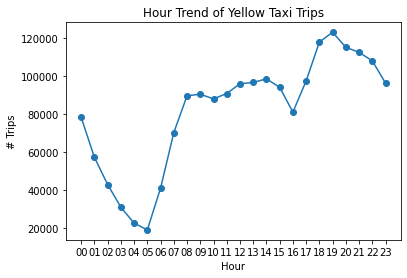

In [149]:
def time_trend_taxi(dataframe: pd.core.frame.DataFrame):
    '''Plot a line chart for the time trend of yellow taxi trips.
    
    Keyword arguments:
    dataframe -- the dataframe for time trend of yellow taxi trips
    '''  
    data = dataframe.sort_values(by="hour", ascending=True)
    plt.plot(data["hour"],data["trip_count"],"o-")
    plt.xlabel('Hour')
    plt.ylabel('# Trips')
    plt.title('Hour Trend of Yellow Taxi Trips')
    plt.show()

def get_time_trend_taxi_data():
    '''Return time trend data for yellow taxi trips.'''
    
    query = """
    SELECT strftime('%H', pickup_datetime) AS hour, 
           COUNT(*) AS trip_count
    FROM taxi_trips
    GROUP BY hour
    ORDER BY trip_count DESC;
    """
    
    df = pd.read_sql_query(query, engine)
    
    return df

time_trend_taxi_dataframe = get_time_trend_taxi_data()
time_trend_taxi(time_trend_taxi_dataframe)

### Visualization 2
Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization

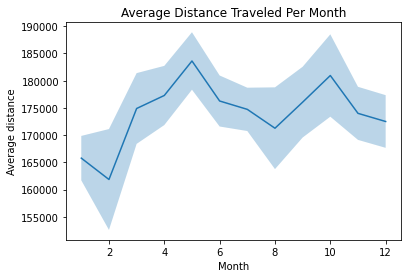

In [150]:
def average_distance_traveled(dataframe):
    '''Plot a line chart average distance traveled
    
    Keyword arguments:
    dataframe -- the dataframe for time trend of yellow taxi trips
    '''  
    # Calculate the lower bound and upper bound
    # print(dataframe)
    dataframe['year_month'] = pd.to_datetime(dataframe['year_month'], format='%Y-%m')
    dataframe = dataframe['distances'].groupby(dataframe['year_month'].dt.month).agg(['mean', 'count', 'sem'])
    dataframe['DegreeOfFreedom'] = dataframe['count'] - 1
    Low_bound, High_bound = stats.t.interval(0.90, dataframe['DegreeOfFreedom'], loc=dataframe['mean'], scale=dataframe['sem'])
    # draw the plot
    plt.plot(dataframe.index, dataframe['mean'])
    plt.fill_between(dataframe.index, Low_bound, High_bound, alpha=0.3)
    plt.xlabel('Month')
    plt.ylabel('Average distance')
    plt.title('Average Distance Traveled Per Month')
    plt.show()
def get_data_for_visual_2():
    '''Return the dataframe used for plotting
    
    Output:
    A dataframe for time trend of average distance traveled for each month
    '''  

    # select the data  
    query_sum_distance1 = '''
    SELECT strftime('%Y-%m', pickup_datetime) AS year_month, SUM(distance) AS distances
    FROM taxi_trips
    GROUP BY year_month 
    '''
    query_sum_distance2 = '''
    SELECT strftime('%Y-%m', pickup_datetime) AS year_month, SUM(distance) AS distances
    FROM uber_trips
    GROUP BY year_month 
    '''

    df1 = pd.read_sql_query(query_sum_distance1, engine)
    df2 = pd.read_sql_query(query_sum_distance2, engine)
    df1['distances'] = df1['distances']+df2['distances']

    return df1
some_dataframe = get_data_for_visual_2()
# print(some_dataframe)
average_distance_traveled(some_dataframe.sort_values(by="year_month", ascending=True))


### Visualization 3
Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.

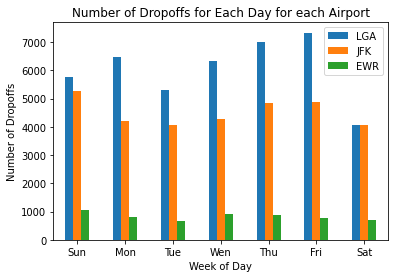

In [151]:
def dropoff_num_for_each_day(dataframes):
    '''Plot a box chart to visualize which day of week is most popular within each group 
    
    Keyword arguments:
    dataframes -- the dataframes containing information for three airports
    '''  
    dataframes[0]['JFK'] = dataframes[1]['JFK']
    dataframes[0]['EWR'] = dataframes[2]['EWR']
    df = dataframes[0]
    df.loc[df["Day"] == '0', "Day"] = "Sun"
    df.loc[df["Day"] == '1', "Day"] = "Mon"
    df.loc[df["Day"] == '2', "Day"] = "Tue"
    df.loc[df["Day"] == '3', "Day"] = "Wen"
    df.loc[df["Day"] == '4', "Day"] = "Thu"
    df.loc[df["Day"] == '5', "Day"] = "Fri"
    df.loc[df["Day"] == '6', "Day"] = "Sat"
    df.plot(x="Day", y=["LGA",'JFK','EWR'], kind="bar",rot = 0, title="Number of Dropoffs for Each Day for each Airport", xlabel="Week of Day", ylabel="Number of Dropoffs")

def get_data_for_visual_3():
    '''Returns a dataframe that contains daily pickup information about three of the airports'''
    LGA_Range = [-73.892126,40.769973,-73.86021,40.781788,'LGA']
    JFK_Range = [-73.826749,40.623256,-73.751329,40.661102,'JFK']
    EWR_Range = [-74.189097,40.674312,-74.150902,40.70881,'EWR']
    df = []
    for i in [LGA_Range, JFK_Range, EWR_Range]:
        query = \
        f'''WITH hired_trips AS (SELECT pickup_datetime,dropoff_longitude,dropoff_latitude
        FROM taxi_trips UNION ALL
        SELECT pickup_datetime,dropoff_longitude,dropoff_latitude FROM uber_trips)
        SELECT strftime('%w', pickup_datetime) AS Day ,COUNT(*) AS {i[4]}
        FROM hired_trips
        WHERE dropoff_longitude >= {i[0]} AND dropoff_longitude <= {i[2]} AND dropoff_latitude >= {i[1]} AND dropoff_latitude <= {i[3]} 
        GROUP BY Day
        '''
        df.append(pd.read_sql_query(query, engine))
    return df

some_dataframe = get_data_for_visual_3()
dropoff_num_for_each_day(some_dataframe)

### Visualization 4
Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.

<ipython-input-44-ba1cf01db38a>:41: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['longitude'] = taxi_zone_df.centroid.x
<ipython-input-44-ba1cf01db38a>:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  taxi_zone_df['latitude'] = taxi_zone_df.centroid.y


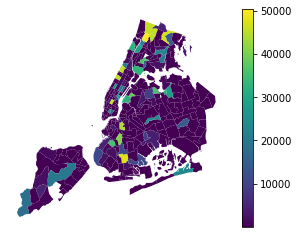

In [152]:

def heatmap_all_hired_trips(dataframe):
    '''Plot a heatmap of all hired trips over the map of that area
    
    Keyword arguments:
    dataframe -- the dataframes containing information for three airports
    '''   
    dataframe.plot(column='count', legend=True, markersize = 15)
    plt.axis('off')
    plt.show()

def get_data_for_visual_4():
    """return a dataframe that can be further used for ploting heatmap"""
    query = '''WITH hired_trips AS (SELECT pickup_latitude AS latitude, pickup_longitude AS longitude
            FROM taxi_trips UNION ALL
            SELECT pickup_latitude AS latitude, pickup_longitude AS longitude FROM uber_trips)
            SELECT latitude, longitude
            FROM hired_trips
            '''
    df = pd.read_sql_query(query, engine)
    
    # reindex the GEO
    geo_loc = get_taxi_zone_df()
    geo_loc = geo_loc.reset_index()

    # join the two dataframes
    df = pd.merge(df, geo_loc, how="outer",on=["latitude", "longitude"])
    df.dropna(subset=["LocationID"], inplace=True)

    geo_loc['count'] = df.groupby("LocationID").count()['longitude']
    return geo_loc
heatmap_all_hired_trips(get_data_for_visual_4())

### Visualization 5

Create a scatter plot that compares tip amount versus distance.

In [153]:

def tip_amount_vs_distance_scatter_plot(dataframe):
    '''Plot a heatmap of all hired trips over the map of that area
    
    Keyword arguments:
    dataframe -- the dataframes containing information for tip amount and travel distance
    '''  
    figure, axes = plt.subplots(figsize=(20, 10))

    axes.scatter("distance","tip_amount", data = dataframe)
    axes.set_title("Tip Amount & Travel Distance")
    axes.set_xlabel("Distance")
    axes.set_ylabel("Tip Amount")
    
    plt.show()

In [154]:
def get_data_for_visual_5():
    """return a dataframe that can be further used for ploting"""
    myquery = \
    '''SELECT tip_amount, distance
    FROM taxi_trips
    '''
    df = pd.read_sql_query(myquery, engine)
    return df

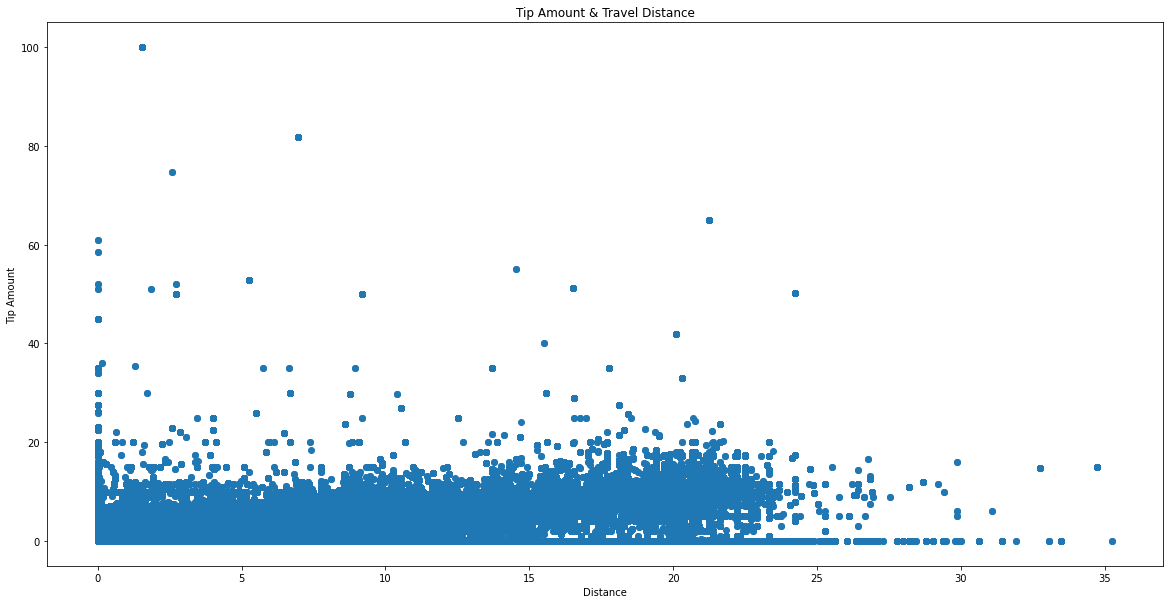

In [155]:
some_dataframe = get_data_for_visual_5()
# print(some_dataframe)
tip_amount_vs_distance_scatter_plot(some_dataframe)

### Visualization 6
Create another scatter plot that compares tip amount versus precipitation amount.

                DATE    tip  precipitation
0      2009-01-01 00  29.12      11.041667
1      2009-01-02 00   0.00       6.806452
2      2009-01-03 00  23.60       9.875000
3      2009-01-04 00  22.00       7.370370
4      2009-01-05 00   2.46       6.925926
...              ...    ...            ...
32643  2015-06-26 00  71.00       0.000000
32644  2015-06-27 00  53.06       2.600000
32645  2015-06-28 00  33.96       0.600000
32646  2015-06-29 00   0.00       0.000000
32647  2015-06-30 00  52.24       0.080000

[32648 rows x 3 columns]


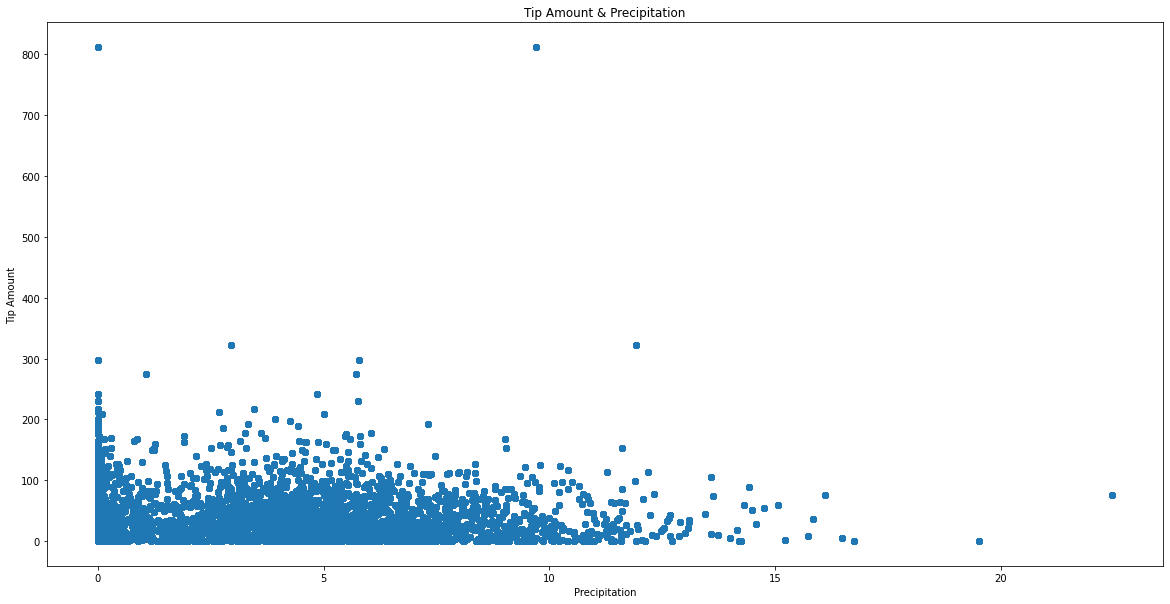

In [156]:
def tip_amount_vs_precipitation_scatter_plot(dataframe):
    '''Create a scatter plot that compares tip amount versus precipitation amount.
    
    Keyword arguments:
    dataframe -- the dataframes containing information for tips and percipitation amount
    '''  
    figure, axes = plt.subplots(figsize=(20, 10))

    axes.scatter("precipitation","tip", data = dataframe)
    axes.set_title("Tip Amount & Precipitation")
    axes.set_xlabel("Precipitation")
    axes.set_ylabel("Tip Amount")
    
    plt.show()

def get_data_for_visual_6():
    '''return a dataframe that contains information about tip amount and precipitation amount'''  
    
    # select the data
    query_precipitation = '''
    Select tips.DATE, tips.tip_amount as tip, Daily.precipitation as precipitation
        From(Select strftime('%Y-%m-%d %H', pickup_datetime) AS DATE, SUM(taxi_trips.tip_amount) AS tip_amount
             From taxi_trips
             GROUP BY DATE) as tips,
            (Select strftime('%Y-%m-%d %H', DATE) AS DATE, DailyPrecipitation AS precipitation
             FROM daily_weather) as Daily
        Where tips.DATE = Daily.DATE
    '''
    df = pd.read_sql_query(query_precipitation, engine)
    return df

some_dataframe = get_data_for_visual_6()
print(some_dataframe)
tip_amount_vs_precipitation_scatter_plot(some_dataframe)
